Python clesperanto Test notebook

In [1]:
'''Using cle_39 env'''
import pyclesperanto_prototype as cle

from skimage.io import imread, imsave



In [2]:

# initialize / select GPU with "TX" in their name
device = cle.select_device("TX")
print("Used GPU: ", device)

# load data
image = imread('https://imagej.nih.gov/ij/images/blobs.gif')

# process the image
inverted = cle.subtract_image_from_scalar(image, scalar=255)
blurred = cle.gaussian_blur(inverted, sigma_x=1, sigma_y=1)
binary = cle.threshold_otsu(blurred)
labeled = cle.connected_components_labeling_box(binary)

# The maximium intensity in a label image corresponds to the number of objects
num_labels = labeled.max()
print(f"Number of objects in the image: {num_labels}")

# save image to disc
imsave("result.tif", labeled)

Used GPU:  <NVIDIA GeForce GTX 1080 Ti on Platform: NVIDIA CUDA (1 refs)>
Number of objects in the image: 63.0


C:\Users\tyler\AppData\Local\Temp\ipykernel_18980\160259026.py:19: UserWarning: result.tif is a low contrast image
  imsave("result.tif", labeled)


Select GPU

In [3]:
# import pyclesperanto_prototype as cle

# list names of all available OpenCL-devices
print("Available OpenCL devices:" + str(cle.available_device_names()))

# list CPUs and GPUs separately
gpu_devices = cle.available_device_names(dev_type="gpu")
print("Available GPU OpenCL devices:" + str(gpu_devices))

cpu_devices = cle.available_device_names(dev_type="cpu")
print("Available CPU OpenCL devices:" + str(cpu_devices))

# selecting an Nvidia RTX
cle.select_device("RTX")
print("Using OpenCL device " + cle.get_device().name)

# selecting an Nvidia GTX
cle.select_device("GTX")
print("Using OpenCL device " + cle.get_device().name)

# selecting an Intel UHD GPU
cle.select_device("Intel")
print("Using OpenCL device " + cle.get_device().name)

# selecting an AMD Vega GPU
cle.select_device("904")
print("Using OpenCL device " + cle.get_device().name)

# selecting an AMD Vega GPU
cle.select_device("902")
print("Using OpenCL device " + cle.get_device().name)

Available OpenCL devices:['NVIDIA GeForce GTX 1080 Ti', 'NVIDIA GeForce GTX 1080 Ti']
Available GPU OpenCL devices:['NVIDIA GeForce GTX 1080 Ti', 'NVIDIA GeForce GTX 1080 Ti']
Available CPU OpenCL devices:[]


c:\Users\tyler\Anaconda3\envs\gpu-analysis\lib\site-packages\pyclesperanto_prototype\_tier0\_device.py:77: UserWarning: No OpenCL device found with RTX in their name. Using NVIDIA GeForce GTX 1080 Ti instead.
  warnings.warn(f"No OpenCL device found with {name} in their name. Using {device.name} instead.")


Using OpenCL device NVIDIA GeForce GTX 1080 Ti


c:\Users\tyler\Anaconda3\envs\gpu-analysis\lib\site-packages\pyclesperanto_prototype\_tier0\_device.py:77: UserWarning: No OpenCL device found with Intel in their name. Using NVIDIA GeForce GTX 1080 Ti instead.
  warnings.warn(f"No OpenCL device found with {name} in their name. Using {device.name} instead.")


Using OpenCL device NVIDIA GeForce GTX 1080 Ti
Using OpenCL device NVIDIA GeForce GTX 1080 Ti
Using OpenCL device NVIDIA GeForce GTX 1080 Ti
Using OpenCL device NVIDIA GeForce GTX 1080 Ti


c:\Users\tyler\Anaconda3\envs\gpu-analysis\lib\site-packages\pyclesperanto_prototype\_tier0\_device.py:77: UserWarning: No OpenCL device found with 904 in their name. Using NVIDIA GeForce GTX 1080 Ti instead.
  warnings.warn(f"No OpenCL device found with {name} in their name. Using {device.name} instead.")
c:\Users\tyler\Anaconda3\envs\gpu-analysis\lib\site-packages\pyclesperanto_prototype\_tier0\_device.py:77: UserWarning: No OpenCL device found with 902 in their name. Using NVIDIA GeForce GTX 1080 Ti instead.
  warnings.warn(f"No OpenCL device found with {name} in their name. Using {device.name} instead.")


Start by comparing timing of similar operations

In [4]:
# Downsampling with current workflow
import os
import numpy as np
import imageio
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import math


from skimage import io, transform
from skimage.util import img_as_float32

In [5]:
# Module imports
import sys
sys.path.append('E://Documents/Professional/Jupyter notebooks/Projects/Iordonova_lab/')
# sys.path.append('brain_segmentations')

from brain_segmentations.config import *
from brain_segmentations.preprocessing.preprocessing import *
from brain_segmentations.preprocessing.file_io import *
from brain_segmentations.registration.registration import *


DS_FACTOR = 16 # Downsampling factor


experiment_folder defined in config. Be careful in the future! Iordanova_06082022_SOC-R9-F_NeuN-cFOS/
Successfully import pyclesperanto, using GPU:  <NVIDIA GeForce GTX 1080 Ti on Platform: NVIDIA CUDA (1 refs)>


In [6]:
# Input
experiment_folder = 'Iordanova_06082022_SOC-R9-F_NeuN-cFOS/'
cFOS_folder = '561nm_NeuN/'
neun_folder = '647nm_cFOS/'


# Output
DS_OUTPUT = 'M://Brain_Registration/downsampled_'+ str(DS_FACTOR)
neun_output = DS_OUTPUT + '/neun-orig/'

create_folder_if_not_exists(neun_output)  

Folder already exists: M://Brain_Registration/downsampled_16/neun-orig/


In [7]:
# Start by selecting and loading an image at random from the dataset

fullres_folder = 'Z://Collaboration_data/Iordonova_lab/Iordanova_06082022_SOC-R9-F_NeuN-cFOS/561nm_NeuN/'
# fos_folder = 'Z://Collaboration_data/Iordonova_lab/Iordanova_06082022_SOC-R9-F_NeuN-cFOS/647nm_cFOS/'

# Get a list of all tif files in the folder 
identifiers = [f[:-4] for f in os.listdir(fullres_folder) if f.endswith('.tif')]


# Get an example identifier halfway through the list
example_identifier = identifiers[len(identifiers) // 2]

print(example_identifier)

# Load this image
full_img = io.imread(fullres_folder + example_identifier + '.tif')


356850_415210_055320


In [8]:
def downsample_image_cle(image, downsample_factor):
    # Calculate the number of iterations needed to achieve the downsample factor
    # We calculate the base 2 logarithm of the downsample factor since each iteration downsamples by half
    iterations = int(math.log(downsample_factor, 2))
    print(iterations)

    # Initialize the downsampled image
    downsampled_image = image

    # Iteratively downsample the image
    for _ in range(iterations):
        downsampled_image = cle.downsample_slice_by_slice_half_median(downsampled_image)

    return downsampled_image



In [9]:
# initialize / select GPU with "TX" in their name
device = cle.select_device("TX")
print("Used GPU: ", device)


Used GPU:  <NVIDIA GeForce GTX 1080 Ti on Platform: NVIDIA CUDA (1 refs)>


In [10]:
# ds_img_ = cle.downsample_slice_by_slice_half_median(full_img)


In [11]:
ds_img = downsample_image(full_img, downsample_factor=DS_FACTOR)

KeyboardInterrupt: 

In [ ]:
ds_img_cle = downsample_image_cle(full_img, downsample_factor=DS_FACTOR)


4


In [ ]:
print(full_img.shape, ds_img.shape, ds_img_cle.shape)

(15988, 10999) (999, 687) (999, 687)


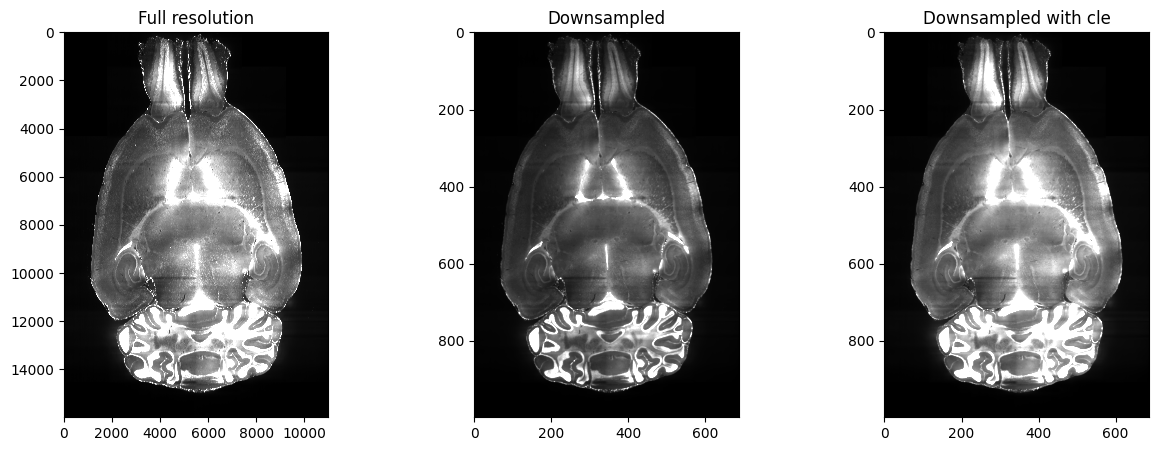

In [ ]:
# Compare the three images side by side
# Make sure display range is equivalent for the pixel values 

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(full_img, cmap='gray', vmin=0, vmax=2000)
ax[0].set_title('Full resolution')
ax[1].imshow(ds_img, cmap='gray', vmin=0, vmax=0.05)
ax[1].set_title('Downsampled')
ax[2].imshow(ds_img_cle, cmap='gray', vmin=0, vmax=2000)
ax[2].set_title('Downsampled with cle')
plt.show()


In [ ]:
# Load the registered atlas (changes for each brain)

atlas_volume = load_atlas_volume(atlas_volume_filename)


Loading registered atla volume from: M://Brain_Registration/brainreg_napari_output/may10_20ds_fullz_preds/registered_atlas_original_orientation.tiff
Atlas shape:  (738, 507, 284)


In [ ]:
# Load the atlas reference keys (unchanging for the atlas)

label_data = parse_itk_snap_label_file(REGION_LABEL_PATH)
keys_list = list(label_data.keys())

# Test the atlas masking using cle.mask()
region_id = 406


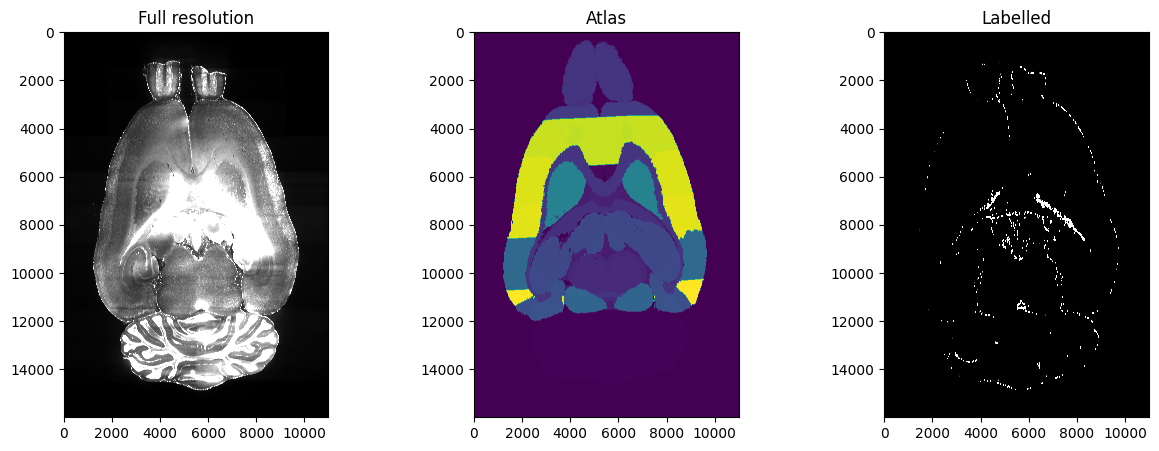

<Figure size 640x480 with 0 Axes>

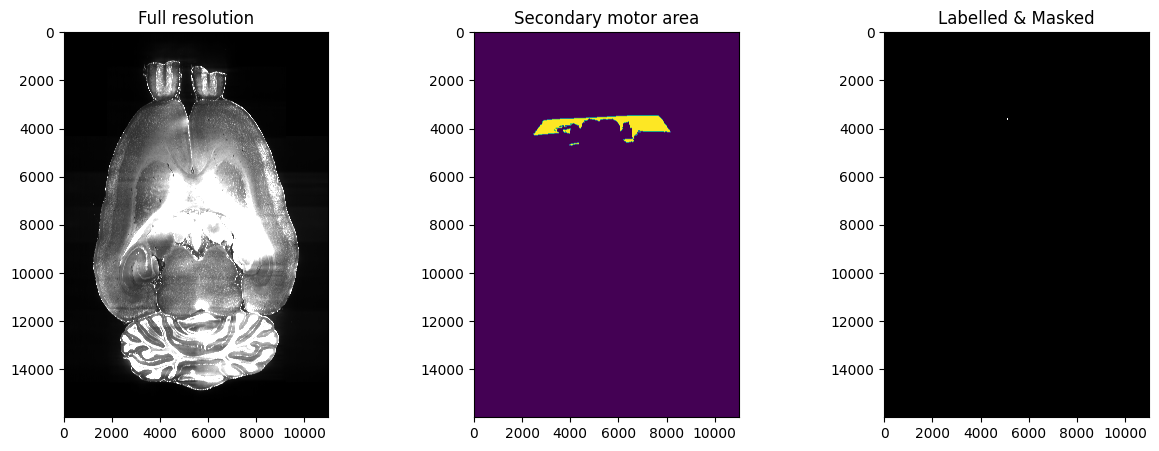

In [ ]:
plot=True

# Use the example slice_id from midway through the stack
slice_id = identifiers[1000]

# Load this image
full_img = io.imread(fullres_folder + slice_id + '.tif') # < 2s

# Once per image, get the slice of the labels volume that corresponds to this image
(img_ind, lab_ind), this_atlas_slice = map_img_to_label(slice_id, identifiers, atlas_volume)

# Scale the label slice to match the image dimensions 
scaled_label_slice = transform.resize(this_atlas_slice, full_img.shape, order=0, preserve_range=True)

# Apply a top hat filter to the image to remove background
tophat_img = cle.top_hat_box(full_img, radius_x=20, radius_y=20)
thresh_img = cle.threshold_otsu(tophat_img)
lab_img = cle.voronoi_otsu_labeling(thresh_img)

if(plot):
    # Compare 3 plots side by side (Expensive operation)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(full_img, cmap='gray', vmin=0, vmax=2000)
    ax[0].set_title('Full resolution')
    ax[1].imshow(scaled_label_slice)#, cmap='gray', vmin=0, vmax=0.05)
    ax[1].set_title('Atlas')
    ax[2].imshow(lab_img, cmap='gray', vmin=0, vmax=1)
    ax[2].set_title('Labelled')
    plt.show()

# # for region_id in keys_list:#tqdm(keys_list):#range(3):
# for region_id in tqdm(list(np.unique(this_atlas_slice))):

'''Do it for example region'''

region_label = label_data[region_id]['label'] # Prints the label for index 1

# Get the mask for this region (it is already scaled up to the full image size), verify..
region_mask = get_mask_from_label(region_id, scaled_label_slice)

# Apply the mask to the image
masked_img = cle.mask(lab_img, region_mask)#, masked_img)

if(plot):
    # Compare 3 plots side by side (Expensive operation)
    plt.clf()
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(full_img, cmap='gray', vmin=0, vmax=2000)
    ax[0].set_title('Full resolution')
    ax[1].imshow(region_mask)#, cmap='gray', vmin=0, vmax=0.05)
    ax[1].set_title(region_label)
    ax[2].imshow(masked_img, cmap='gray', vmin=0, vmax=1)
    ax[2].set_title('Labelled & Masked')
    plt.show()


Now try some image processing steps to segment

In [ ]:
eroded_otsu = cle.eroded_otsu_labeling(full_img)

NameError: name 'full_img' is not defined

In [ ]:
gaus_otsu = cle.gauss_otsu_labeling(full_img)

In [ ]:
voronoi_otsu =cle.voronoi_otsu_labeling(full_img)

In [ ]:
from matplotlib.patches import Rectangle

#Compare the three images side by side in the first row
# In the second row, show aclose up view of the image.

crop_loc = [12000,12500,7500,8000] # Crop location


In [ ]:

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].imshow(eroded_otsu, cmap='gray')
ax[0, 0].set_title('Eroded Otsu')
ax[0, 1].imshow(gaus_otsu, cmap='gray')
ax[0, 1].set_title('Gaussian Otsu')
ax[0, 2].imshow(voronoi_otsu, cmap='gray')
ax[0, 2].set_title('Voronoi Otsu')  

for i in range(3):
    # Create a rectangle patch for each Axes
    crop_rect = Rectangle((crop_loc[2], crop_loc[0]),  # (x,y)
                          crop_loc[3] - crop_loc[2],  # width
                          crop_loc[1] - crop_loc[0],  # height
                          linewidth=1,
                          edgecolor='r',
                          facecolor='none')

    # Add the rectangle to the Axes
    ax[0, i].add_patch(crop_rect)

    
ax[1, 0].imshow(eroded_otsu[crop_loc[0]:crop_loc[1],crop_loc[2]:crop_loc[3]], cmap='gray')
ax[1, 0].set_title('Eroded Otsu')
ax[1, 1].imshow(gaus_otsu[crop_loc[0]:crop_loc[1],crop_loc[2]:crop_loc[3]], cmap='gray')
ax[1, 1].set_title('Gaussian Otsu')
ax[1, 2].imshow(voronoi_otsu[crop_loc[0]:crop_loc[1],crop_loc[2]:crop_loc[3]], cmap='gray')
ax[1, 2].set_title('Voronoi Otsu')
plt.show()





Build up a processing Pipeline


In [ ]:
filt_img = cle.top_hat_box(full_img, radius_x=20, radius_y=20)

In [ ]:
thresh_img = cle.threshold_otsu(filt_img)

In [ ]:
lab_img =cle.voronoi_otsu_labeling(thresh_img)

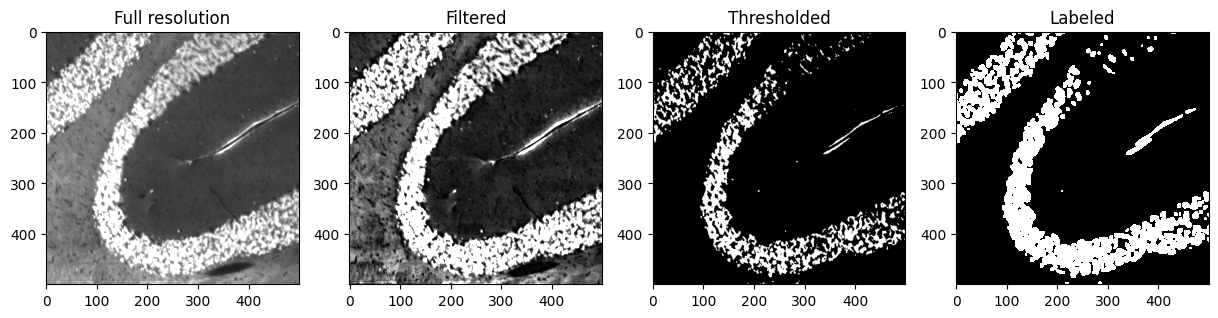

In [ ]:
# for sigma in tqdm(np.linspace(0.1, 10, 10)):

#     print(sigma)
#     voronoi_otsu =cle.voronoi_otsu_labeling(full_img,spot_sigma = sigma)
    # plt.clf()
    # plt.imshow(voronoi_otsu[crop_loc[0]:crop_loc[1],crop_loc[2]:crop_loc[3]], cmap='gray')
    # plt.show()


# Show side by side this zoomed in view of the original image, the filtered image, and the labeled image
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].imshow(full_img[crop_loc[0]:crop_loc[1],crop_loc[2]:crop_loc[3]], cmap='gray', vmin=0, vmax=5000)
ax[0].set_title('Full resolution')
ax[1].imshow(filt_img[crop_loc[0]:crop_loc[1],crop_loc[2]:crop_loc[3]], cmap='gray', vmin=0, vmax=2000)
ax[1].set_title('Filtered')
ax[2].imshow(thresh_img[crop_loc[0]:crop_loc[1],crop_loc[2]:crop_loc[3]], cmap='gray', vmin=0, vmax=1)
ax[2].set_title('Thresholded')
ax[3].imshow(lab_img[crop_loc[0]:crop_loc[1],crop_loc[2]:crop_loc[3]], cmap='gray', vmin=0, vmax=1)
ax[3].set_title('Labeled')
plt.show()




In [ ]:

this_crop = lab_img[crop_loc[0]:crop_loc[1],crop_loc[2]:crop_loc[3]]
print(len(np.unique(this_crop)))

#Warning: We may not be able to use this to actually count cells because in a given slice we'll approach the maximum number of labels.
print(len(np.unique(lab_img)))

455
